#### Libraries: Biopython, pandas, sqlite3 & ...

In [1]:
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio.SeqIO import FastaIO
from ete3 import NCBITaxa
import os
import math
import matplotlib
import argparse
import numpy as np
import sqlite3
from sqlite3 import Error
import datetime
import collections

#### Initialization

In [41]:
mode = 'stats'
# db_path = 'clio_sqlite.db'
db_path = 'clio_sqlite.db'
output_dir = 'output/'
taxonomy_group = "Metazoa"
marker = "COI" # 12S
markers = ["12S","16S","COI","SSU"]
min_length = 60
cluster = False
elements = [
    "record_id", "sequences",
    "kingdom_name", "kingdom",
    "phylum_name", "phylum",
    "class_name", "class",
    "order_name", "order",
    "family_name","family",
    "genus_name", "genus",
    "species_name", "species",
    "taxid", "marker",
    "database", "extra",
    "genbank_accession","bin_uri",
    "import_file"
]
ranks_verbose = {
    "kingdom":"kingdoms",
    "phylum":"phyla",
    "class":"classes",
    "order":"orders",
    "family":"families",
    "genus":"genera",
    "species":"species"
}

#### Command line arguments

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('mode', choices=["overview", "stats", "fasta", "blast"])
parser.add_argument('output',help='The path to the output folder')
parser.add_argument('database', help='clio_sqlite.db path')
parser.add_argument('taxa', help='Target taxonomy group "Capitalized"')
parser.add_argument('marker', choices=markers, help='Marker, 12S is default')
parser.add_argument(
    'min_length', help='Minimum length selection. default: 10 bp')

args = parser.parse_args()

mode = args.mode
output_dir = args.output
db_path = args.database
taxonomy_group = args.taxa
marker = args.marker
min_length = int(args.min_length)

if args.mode:
    cluster = True
    matplotlib.use('Agg')

usage: ipykernel_launcher.py [-h]
                             {overview,stats,fasta,blast} output database taxa
                             {12S,16S,COI,SSU} min_length
ipykernel_launcher.py: error: argument mode: invalid choice: '/run/user/1010/jupyter/kernel-de025105-2b27-4479-93ba-a88210cb256c.json' (choose from 'overview', 'stats', 'fasta', 'blast')


SystemExit: 2

/home/mvafadar/Programs/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2886: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


#### NCBI Taxonomy Database

In [42]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)
ncbi = NCBITaxa()
# ncbi.update_taxonomy_database()


In [19]:
def get_direct_descendants(taxa, lower_rank):
    descendants = ncbi.get_descendant_taxa(
        taxa, collapse_subspecies=True, rank_limit=lower_rank)
    children = list()
    for child in descendants:
        the_rank = ncbi.get_rank([child]).values()[0]
        if lower_rank in the_rank:
            children.append(child)
    return children

In [20]:
def plot_maker(names, av, to, desc, obj_name, rank_name):
    max_to = max(to)
    plt.rcdefaults()
    fig, ax = plt.subplots()
    y_pos = np.arange(len(names))
    colors = ['red', 'green']
    bar1 = ax.barh(y_pos, av, align='center', color='red',
                   ecolor='black', height=0.5)
    bar2 = ax.barh(y_pos, to, align='center',  color='blue',
                   ecolor='black', alpha=0.5, height=0.5)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(names)
    ax.set_xlabel('Number')
    ax.set_xbound(upper=max_to*1.05)
    ax.text
    ax.set_title('Coverage of {} in Clio among {} {} of {}'.format(
        marker, len(to), ranks_verbose[rank_name], obj_name))
    y_length = (10 if len(names)/3 < 10 else len(names)/3)
    fig.set_size_inches(10, y_length)

    for i, (a, t, d) in enumerate(zip(av, to, desc)):
        ax.text(a + 1, i - 0.2, '{} / {} {}'.format(str(a),
                                                    str(t), str(d)), color='black')

    #         plt.show()
    plot_name = marker + "_" + taxonomy_group + \
        "_" + "coverage.png".format(obj_name)
    fig.savefig(output_dir + plot_name, bbox_inches='tight',)
    plt.close(fig)

In [21]:
def charter(chart, obj_name, rank_name):
    names = list()
    av = list()
    to = list()
    desc = list()
    sorted_chart = sorted(chart, key=lambda tup: tup[0], reverse=True)
    chart_file = open(output_dir + marker + obj_name + "_" + rank_name + "chart.txt", "w")
    chart_file.writelines(str(sorted_chart))
    chart_file.close()
    for rec in sorted_chart:
        names.append(rec[0])
        av.append(rec[1])
        to.append(rec[2])
        desc.append(rec[3])
        if to.count > 0:
            plot_maker(names, av, to, desc, obj_name, rank_name)
    return names

#### SQL Database functions

In [22]:
def create_connection(db_file):
    #     db_file = "genbank_sqlite.db"
    """ create a database connection to a SQLite database """
    try:
        conn = sqlite3.connect(db_file)  # RAM: (':memory:')
        print "----------------------------------------"
        print "| DB overview - (sqlite version:" + sqlite3.version + ") |"
        print "----------------------------------------\n"
        return conn
    except Error as e:
        print(e)
#     finally:
#         conn.close()
    return None

In [23]:
def select_record(conn, taxonomy_group, marker):
    cur = conn.cursor()

    cur.execute(
        """SELECT * FROM barcode WHERE marker = '{0}' AND 
        ( kingdom_name = '{1}' OR
        phylum_name = '{1}' OR
        class_name = '{1}' OR
        order_name = '{1}' OR
        family_name = '{1}')""".format(marker, taxonomy_group))

    rows = cur.fetchall()
#     conn.close()

    if len(rows) > 0:
        return rows
    else:
        print "No record found for " + taxonomy_group + " and " + marker
        return rows

In [11]:
def select_rank(conn, taxa, rank, marker):
    cur = conn.cursor()
    command = '''SELECT count(record_id)
    FROM barcode 
    WHERE "{}" = "{}" AND marker = "{}" '''.format(rank, taxa, marker)
#     print command
    cur.execute(command)

    count = cur.fetchone()
    return count[0]

In [36]:
def overview(conn):
    cur = conn.cursor()

    global markers

#     for db in
    for m in markers:
        cur.execute(
            "SELECT count(database) FROM barcode WHERE marker = '{}';".format(m))
        counts = cur.fetchall()
        cur.execute(
            """SELECT count(DISTINCT species_name)
            FROM barcode
            WHERE marker = '{}';""".format(m))
        taxids = cur.fetchall()
        print m + ": " + str(counts[0][0]) + " records." + \
            " # of unique species_name: " + str(taxids[0][0])

        cur.execute(
            "SELECT DISTINCT database FROM barcode WHERE marker = '{}';".format(m))
        databases = cur.fetchall()
        for db in databases:
            cur.execute(
                """SELECT database, count(record_id)
                FROM barcode 
                WHERE database = '{}' AND marker = '{}';""".format(db[0], m))
            dbs = cur.fetchall()[0]
            print "   " + "# " + str(dbs[0]) + ": " + str(dbs[1])

    return 0

#### Query the overview of the database

In [ ]:
seq_records = list()
print ("started at: " + str(datetime.datetime.now()))
print "output mode: " + mode
conn = create_connection(db_path)
overview(conn)

if mode == 'fasta' or mode == 'stats':
    seq_records = select_record(conn,taxonomy_group,marker)
conn.close()
if len(seq_records) > 0:
    print "\nquery count: " + str(len(seq_records)) 
    print "----------------------------------------"
else:
    print  "\nquery count: 0"

started at: 2019-07-26 16:02:52.064889
output mode: stats
----------------------------------------
| DB overview - (sqlite version:2.6.0) |
----------------------------------------

12S: 240 records. # of unique species_name: 151
   # refseq: 240
16S: 815 records. # of unique species_name: 391
   # refseq: 815
COI: 3948954 records. # of unique species_name: 136832
   # bold: 3927075
   # refseq: 21879
SSU: 25544 records. # of unique species_name: 20676
   # silva: 25544


#### Output files

In [38]:
if 'fasta' in mode or 'blast' in mode:
    output_vsearch_handle = open(
        output_dir + "/clio_" + taxonomy_group + "_" + marker + "_vsearch.fasta", "w")
    fasta_vsearch_out = FastaIO.FastaWriter(output_vsearch_handle)
    fasta_vsearch_out.write_header()
    output_obi_handle = open(output_dir + "/clio_" +
                             taxonomy_group + "_" + marker + "_obi.fasta", "w")
    fasta_obi_out = FastaIO.FastaWriter(output_obi_handle)
    fasta_obi_out.write_header()
    taxid_map_file = open(output_dir + "/clio_" + taxonomy_group + "_" + marker + "taxid_map.txt", "w")

#### Extract the database to files

In [39]:
if 'fasta' in mode or 'blast' in mode:
    for seq_record in seq_records:
        if len(seq_record[1]) >= min_length:
            taxonomy = ";tax="
            desc = ""
            # GENERAL
            if seq_record[16]:
                desc = elements[16] + "=" + str(seq_record[16]) + "; "
            if seq_record[17]:
                desc += elements[17] + "=" + str(seq_record[17]) + "; "
            if seq_record[18]:
                desc += elements[18] + "=" + str(seq_record[18]) + "; "
            if seq_record[19]:
                desc += elements[19] + "=" + str(seq_record[19]) + "; "

            # VSEARCH FORMAT TAXONOMY
            for i in range(2, 15, 2):
                rank = elements[i]
                if seq_record[i] is not None:
                    taxonomy += rank[0] + ":" + seq_record[i] + ","

            # OBI FORMAT TAXONOMY
            taxonomy = ""
            for i in range(2, 16):
                rank = elements[i]
                if seq_record[i] is not None:
                    taxonomy += (rank + '=' + str(seq_record[i]) + '; ')

            seq_record1 = SeqRecord(
                id=seq_record[0]+taxonomy[:-1]+'; ',
                seq=Seq(seq_record[1]),
                description=desc)
            fasta_vsearch_out.write_record(seq_record1)
            seq_record2 = SeqRecord(id=seq_record[0], seq=Seq(
                seq_record[1]), description=taxonomy + desc)
            fasta_obi_out.write_record(seq_record2)
            taxid_map_file.write(seq_record[0] + " " + seq_record[16] + "\n")
    
    output_vsearch_handle.close()
    output_obi_handle.close()
    taxid_map_file.close()
print ("finished at: " + str(datetime.datetime.now()))

finished at: 2019-07-26 15:47:45.630342


#### Extract the length distribution and taxonomy coverage plot

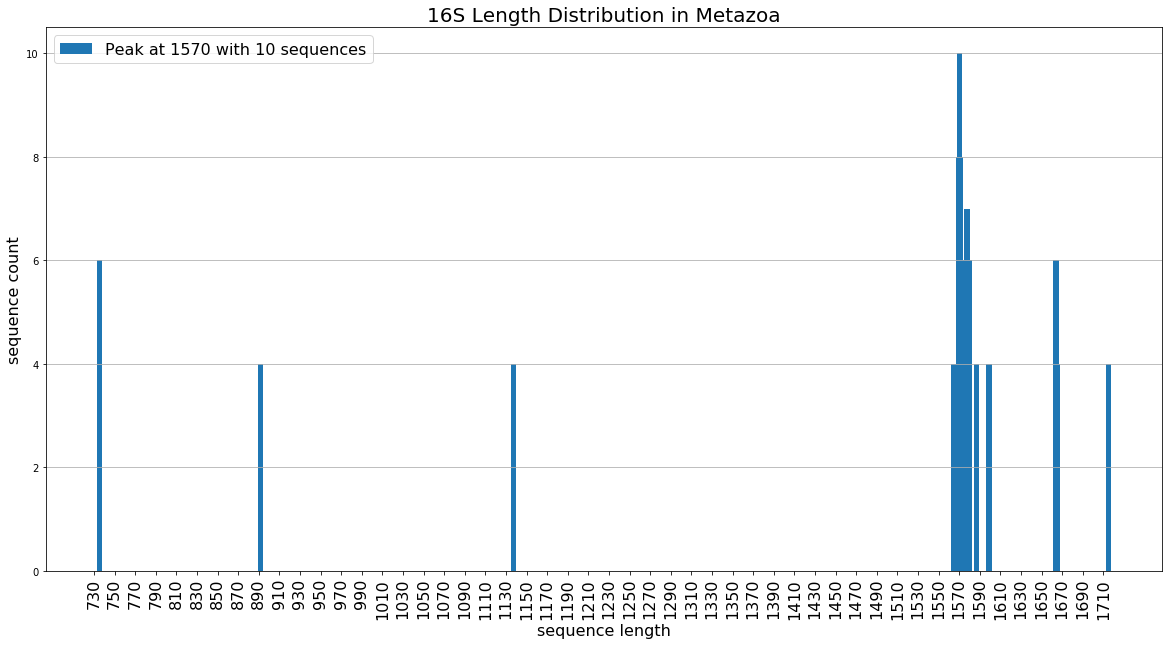

In [40]:
seq_lengths = dict()
seq_length = dict()
if 'stats' in mode:
    for seq_record in seq_records:
        if len(seq_record[1]) >= min_length:
            # length distribution
            if len(seq_record[1]) in seq_lengths:
                seq_lengths[len(seq_record[1])] += 1
            else:
                seq_lengths[len(seq_record[1])] = 1
    for seq in seq_lengths:
        if seq_lengths[seq] > 3:
            seq_length[seq] = seq_lengths[seq]

    # Length distribution in txt file
    od = collections.OrderedDict(sorted(seq_length.items()))
    ld_file = open(output_dir + marker + '_' +
                   taxonomy_group + '_length_distribution.txt', "w+")
    for obj in od:
        ld_file.write("{}:{}\n".format(obj, od[obj]))
    ld_file.close()

    # Plot of length distribution in PDF
    peak_length = str([k for k, v in od.items() if str(v)
                       == str(max(od.values()))][0])
    peak_count = str(max(od.values()))
    plt.figure(figsize=(20, 10),)
    # y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
    # plt.gca()
    plt.bar(*zip(*sorted(seq_length.items()))  ,width=5)
    plt.grid(axis='y')
    plt.xlabel('sequence length', fontsize=16)
    plt.ylabel('sequence count', fontsize=16)
    key_list = list()
#     for k in od.keys():
#         key_list.append(str(k))
    plt.xticks(np.arange(math.floor(min(od.keys()) / 10) * 10,
                         max(od.keys()), 20), rotation='vertical', fontsize=16)
    step = 10  # math.floor((max(od.values())+10)/10 / 10) * 10
#     plt.yticks(np.arange(0,max(od.values()),step),fontsize=16)
    plt.title(marker + ' Length Distribution in ' +
              taxonomy_group, fontsize=20)
    note = mpatches.Patch(label="Peak at " + peak_length +
                          " with " + peak_count + " sequences")

    plt.legend(handles=[note], loc=0, prop={'size': 16})
    plt.savefig(output_dir + marker + '_' +
                taxonomy_group + '_length_distribution.png')
    if not cluster:
        plt.show()

#### Plot the taxonomy coverage

In [ ]:
if 'stats' in mode:
    ranks = elements[3:16:2]
    taxonomy_id = ncbi.get_name_translator([taxonomy_group]).values()[0]
    rank = ncbi.get_rank(taxonomy_id).values()[0]
    index = ranks.index(rank)
    children = get_direct_descendants(taxonomy_group, ranks[index+1])
    clade = list()
    conn = create_connection(db_path)

    for ch in children:
        grandchildren = list()
        taxa = ncbi.translate_to_names([ch])[0]
        grandchildren = get_direct_descendants(ch, ranks[index+2])
        l = 0
        while len(grandchildren) == 0:
            l += 1
            grandchildren = get_direct_descendants(ch, ranks[index+2+l])
        available = 0
        for g in grandchildren:
            if select_rank(conn, g, ranks[index+2+l], marker) > 0:
                available += 1
        row = (taxa, available, len(grandchildren),
               ranks_verbose[ranks[index+2+l]])
#         print row
        clade.append(row)
    conn.close()
    charter(clade, taxonomy_group, ranks[index+1])